# --------------------------------------------
# Notebook: MLP_activations_experiment.ipynb
# Purpose: Study impact of activation functions on MLP performance.
# Dataset: sklearn.datasets.load_digits
# Models: sklearn.neural_network.MLPClassifier
# Outputs: plots + CSV + classification reports + confusion matrices
# Saves artifacts to ./mlp_activation_experiment
# --------------------------------------------

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
OUT_DIR = "./mlp_activation_experiment"
os.makedirs(OUT_DIR, exist_ok=True)

print("Output directory:", OUT_DIR)

Output directory: ./mlp_activation_experiment


In [3]:
digits = load_digits()
X = digits.data
y = digits.target

# Use stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Standardize (important for neural nets)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dataset shapes:", X_train.shape, X_test.shape)

Dataset shapes: (1437, 64) (360, 64)


In [4]:
activations = ["identity", "logistic", "tanh", "relu"]
hidden_layers = (128, 64)   # fixed architecture for fair comparison
max_iter = 150              # limit iterations to keep experiments quick
random_state = 42

# We'll collect results in a list of dicts
results = []

In [5]:
for act in activations:
    print(f"\n--- Training activation = {act} ---")
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=act,
        solver="adam",
        alpha=1e-4,
        learning_rate="adaptive",
        max_iter=max_iter,
        random_state=random_state,
        early_stopping=False,
        verbose=False
    )
    start = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time() - start

    # retrieve loss curve if available
    loss_curve = getattr(clf, "loss_curve_", None)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    cls_report_str = classification_report(y_test, test_pred)
    # store results
    results.append({
        "activation": act,
        "hidden_layers": str(hidden_layers),
        "max_iter": max_iter,
        "train_accuracy": float(train_acc),
        "test_accuracy": float(test_acc),
        "fit_time_sec": float(elapsed),
        "loss_curve": list(loss_curve) if loss_curve is not None else [],
        "loss_curve_len": len(loss_curve) if loss_curve is not None else 0,
        "classification_report": cls_report_str
    })
    print(f"Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f} | time: {elapsed:.2f}s | loss_curve_len: {len(loss_curve) if loss_curve is not None else 0}")


--- Training activation = identity ---
Train acc: 1.0000 | Test acc: 0.9528 | time: 1.79s | loss_curve_len: 124

--- Training activation = logistic ---


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Train acc: 0.9979 | Test acc: 0.9639 | time: 10.46s | loss_curve_len: 150

--- Training activation = tanh ---
Train acc: 1.0000 | Test acc: 0.9694 | time: 3.88s | loss_curve_len: 119

--- Training activation = relu ---
Train acc: 1.0000 | Test acc: 0.9694 | time: 1.38s | loss_curve_len: 81


In [6]:
summary_df = pd.DataFrame([{
    "activation": r["activation"],
    "train_accuracy": r["train_accuracy"],
    "test_accuracy": r["test_accuracy"],
    "fit_time_sec": r["fit_time_sec"],
    "loss_curve_len": r["loss_curve_len"]
} for r in results]).sort_values("test_accuracy", ascending=False).reset_index(drop=True)

csv_path = os.path.join(OUT_DIR, "activation_results_summary.csv")
summary_df.to_csv(csv_path, index=False)
print("\nSaved summary CSV to:", csv_path)
print(summary_df)


Saved summary CSV to: ./mlp_activation_experiment/activation_results_summary.csv
  activation  train_accuracy  test_accuracy  fit_time_sec  loss_curve_len
0       relu        1.000000       0.969444      1.378004              81
1       tanh        1.000000       0.969444      3.878668             119
2   logistic        0.997912       0.963889     10.458039             150
3   identity        1.000000       0.952778      1.788170             124


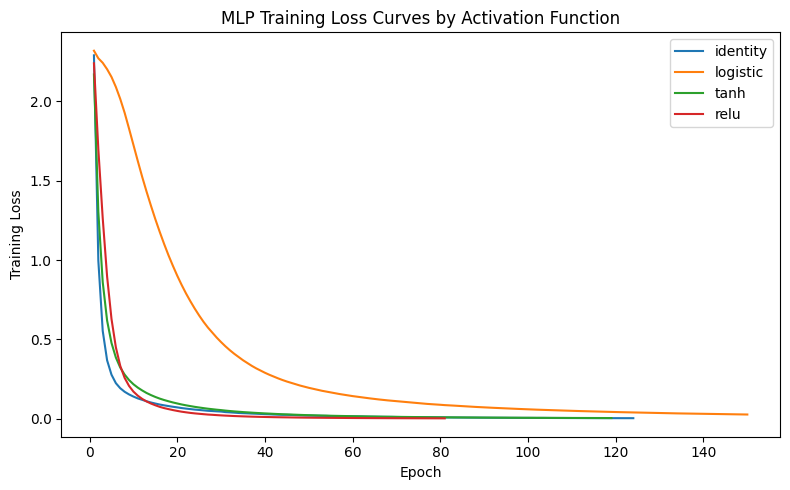

Saved loss curves plot to: ./mlp_activation_experiment/loss_curves_by_activation.png


In [7]:
plt.figure(figsize=(8,5))
for r in results:
    lc = r["loss_curve"]
    if lc:
        epochs = np.arange(1, len(lc)+1)
        plt.plot(epochs, lc, label=r["activation"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MLP Training Loss Curves by Activation Function")
plt.legend()
loss_plot_file = os.path.join(OUT_DIR, "loss_curves_by_activation.png")
plt.tight_layout()
plt.savefig(loss_plot_file)
plt.show()
print("Saved loss curves plot to:", loss_plot_file)

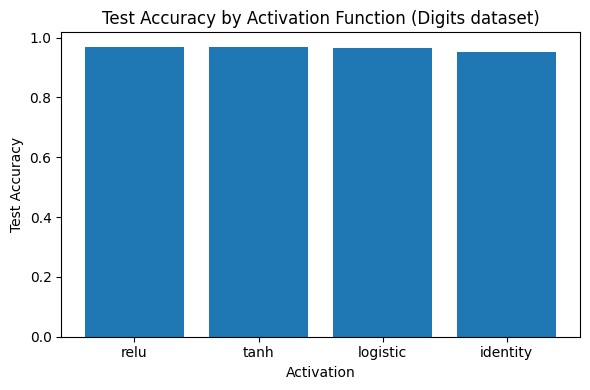

Saved accuracy bar chart to: ./mlp_activation_experiment/test_accuracy_by_activation.png


In [8]:
#Plot test accuracy bar chart
plt.figure(figsize=(6,4))
plt.bar(summary_df["activation"], summary_df["test_accuracy"])
plt.xlabel("Activation")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy by Activation Function (Digits dataset)")
acc_plot_file = os.path.join(OUT_DIR, "test_accuracy_by_activation.png")
plt.tight_layout()
plt.savefig(acc_plot_file)
plt.show()
print("Saved accuracy bar chart to:", acc_plot_file)

In [9]:
for r in results:
    act = r["activation"]
    # we re-fit a classifier (same hyperparameters) to produce confusion matrix file
    clf_temp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=act, solver="adam", max_iter=max_iter, random_state=random_state)
    clf_temp.fit(X_train, y_train)
    cm = confusion_matrix(y_test, clf_temp.predict(X_test))
    cm_df = pd.DataFrame(cm, index=digits.target_names, columns=digits.target_names)
    cm_path = os.path.join(OUT_DIR, f"confusion_matrix_{act}.csv")
    cm_df.to_csv(cm_path)
    # classification report text
    report_path = os.path.join(OUT_DIR, f"classification_report_{act}.txt")
    with open(report_path, "w") as f:
        f.write(f"Activation: {act}\n\n")
        f.write(r["classification_report"])
    print(f"Saved artifacts for {act} -> {cm_path}, {report_path}")

Saved artifacts for identity -> ./mlp_activation_experiment/confusion_matrix_identity.csv, ./mlp_activation_experiment/classification_report_identity.txt


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved artifacts for logistic -> ./mlp_activation_experiment/confusion_matrix_logistic.csv, ./mlp_activation_experiment/classification_report_logistic.txt
Saved artifacts for tanh -> ./mlp_activation_experiment/confusion_matrix_tanh.csv, ./mlp_activation_experiment/classification_report_tanh.txt
Saved artifacts for relu -> ./mlp_activation_experiment/confusion_matrix_relu.csv, ./mlp_activation_experiment/classification_report_relu.txt


In [10]:
print("\nAll saved files in", OUT_DIR)
for fn in sorted(os.listdir(OUT_DIR)):
    print(" -", fn)


All saved files in ./mlp_activation_experiment
 - activation_results_summary.csv
 - classification_report_identity.txt
 - classification_report_logistic.txt
 - classification_report_relu.txt
 - classification_report_tanh.txt
 - confusion_matrix_identity.csv
 - confusion_matrix_logistic.csv
 - confusion_matrix_relu.csv
 - confusion_matrix_tanh.csv
 - loss_curves_by_activation.png
 - test_accuracy_by_activation.png
